In [1]:
import os

import seaborn as sns

from ray import init, rllib, tune, shutdown

In [2]:
from attack_simulator.agents import ATTACKERS
from attack_simulator.env import AttackSimulationEnv
from attack_simulator.graph import AttackGraph, SIZES

In [3]:
graphs = [AttackGraph(dict(graph_size=size)) for size in SIZES]
attackers = list(ATTACKERS)
attackers

AttackGraph(en2720.yaml[tiny], 2 services, 7 attack steps)
AttackGraph(en2720.yaml[small], 5 services, 27 attack steps)
AttackGraph(en2720.yaml[medium], 13 services, 56 attack steps)
AttackGraph(en2720.yaml[large], 16 services, 62 attack steps)
AttackGraph(en2720.yaml[extra-large], 16 services, 65 attack steps)
AttackGraph(en2720.yaml[full], 18 services, 78 attack steps)


['well-informed', 'informed', 'round-robin', 'random']

In [4]:
# Two blank lines added to please `flakehell lint`


class NoAction(rllib.policy.Policy):
    def compute_actions(self, observations, *args, **kwargs):
        return [0 for _ in observations], [], {}

    def learn_on_batch(self, samples):
        return {}

    def get_weights(self):
        return {}

    def set_weights(self, weights):
        pass

    def load_batch_into_buffer(self, batch, buffer_index=0):
        return 0

    def get_num_samples_loaded_into_buffer(self, buffer_index=0):
        return 0

    def learn_on_loaded_batch(self, offset, buffer_index=0):
        return {}


no_action = rllib.agents.trainer_template.build_trainer(name="NoAction", default_policy=NoAction)

In [5]:
if os.path.isdir("/var/run/secrets/kubernetes.io"):  # inside k8s pod
    args = dict(address="auto")
else:  # listen on all interfaces inside a container for port-forwarding to work
    dashboard_host = "0.0.0.0" if os.path.exists("/.dockerenv") else "127.0.0.1"
    args = dict(num_cpus=4, dashboard_host=dashboard_host)

init(**args)

2021-08-24 17:14:29,973	INFO services.py:1263 -- View the Ray dashboard at http://172.17.0.2:8265


{'node_ip_address': '172.17.0.2',
 'raylet_ip_address': '172.17.0.2',
 'redis_address': '172.17.0.2:6379',
 'object_store_address': '/tmp/ray/session_2021-08-24_17-14-29_144305_26586/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-08-24_17-14-29_144305_26586/sockets/raylet',
 'webui_url': '172.17.0.2:8265',
 'session_dir': '/tmp/ray/session_2021-08-24_17-14-29_144305_26586',
 'metrics_export_port': 51783,
 'node_id': 'ed3483fc9609100b021fcd9b5e9b758b13ec6d43e385c34e2115c7c2'}

In [6]:
config = dict(
    framework="torch",
    env=AttackSimulationEnv,
    env_config=dict(attack_graph=tune.grid_search(graphs), attacker=tune.grid_search(attackers)),
    num_workers=1,
    train_batch_size=1,
    rollout_fragment_length=1,
    batch_mode="complete_episodes",
    gamma=1.0,
    seed=tune.grid_search([g.num_attacks for g in graphs]),
)

num_episodes = 5  # run 5 episodes on the same environment

In [7]:
results = tune.run(
    no_action,
    config=config,
    stop=dict(training_iteration=num_episodes),
    progress_reporter=tune.JupyterNotebookReporter(overwrite=True),
)

Trial name,status,loc,env_config/attack_graph,env_config/attacker,seed,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
NoAction_AttackSimulationEnv_be8ec_00000,TERMINATED,,"AttackGraph(en2720.yaml[tiny], 2 services, 7 attack steps)",well-informed,7,5,0.0878181,462,-8067.2,-578,-14119,92.4
NoAction_AttackSimulationEnv_be8ec_00001,TERMINATED,,"AttackGraph(en2720.yaml[small], 5 services, 27 attack steps)",well-informed,7,5,0.561647,2235,-60348.2,-24188,-96988,447
NoAction_AttackSimulationEnv_be8ec_00002,TERMINATED,,"AttackGraph(en2720.yaml[medium], 13 services, 56 attack steps)",well-informed,7,5,0.664239,2182,-104358,-56718,-145537,436.4
NoAction_AttackSimulationEnv_be8ec_00003,TERMINATED,,"AttackGraph(en2720.yaml[large], 16 services, 62 attack steps)",well-informed,7,5,1.03533,2895,-115192,-98066,-132588,579
NoAction_AttackSimulationEnv_be8ec_00004,TERMINATED,,"AttackGraph(en2720.yaml[extra-large], 16 services, 65 attack steps)",well-informed,7,5,1.12556,2812,-132859,-100725,-167855,562.4
NoAction_AttackSimulationEnv_be8ec_00005,TERMINATED,,"AttackGraph(en2720.yaml[full], 18 services, 78 attack steps)",well-informed,7,5,2.36491,4167,-181208,-88492,-263377,833.4
NoAction_AttackSimulationEnv_be8ec_00006,TERMINATED,,"AttackGraph(en2720.yaml[tiny], 2 services, 7 attack steps)",informed,7,5,0.0853286,462,-8067.2,-578,-14119,92.4
NoAction_AttackSimulationEnv_be8ec_00007,TERMINATED,,"AttackGraph(en2720.yaml[small], 5 services, 27 attack steps)",informed,7,5,0.581128,2235,-60348.2,-24188,-96988,447
NoAction_AttackSimulationEnv_be8ec_00008,TERMINATED,,"AttackGraph(en2720.yaml[medium], 13 services, 56 attack steps)",informed,7,5,0.670287,2182,-104358,-56718,-145537,436.4
NoAction_AttackSimulationEnv_be8ec_00009,TERMINATED,,"AttackGraph(en2720.yaml[large], 16 services, 62 attack steps)",informed,7,5,1.09373,2895,-115192,-98066,-132588,579


2021-08-24 17:19:23,813	INFO tune.py:561 -- Total run time: 293.13 seconds (292.78 seconds for the tuning loop).


In [8]:
shutdown()

In [9]:
rename = {
    "config.env_config.attack_graph": "graph",
    "config.env_config.attacker": "Attacker",
    "hist_stats.episode_reward": "returns",
    "hist_stats.episode_lengths": "lengths",
}

df = results.results_df[rename.keys()].rename(columns=rename)
df["Graph size"] = df["graph"].apply(lambda g: g.num_attacks)
del df["graph"]
df["tuple"] = df.apply(lambda t: list(zip(t.returns, t.lengths)), axis="columns")
del df["returns"]
del df["lengths"]
df = df.explode("tuple", ignore_index=True)
df[["Returns", "Episode lengths"]] = df["tuple"].tolist()
del df["tuple"]
df

,Attacker,Graph size,Returns,Episode lengths
0,well-informed,7,-578.0,47.0
1,well-informed,7,-10308.0,113.0
2,well-informed,7,-10547.0,22.0
3,well-informed,7,-14119.0,32.0
4,well-informed,7,-4784.0,248.0
...,...,...,...,...
715,random,78,-142574.0,592.0
716,random,78,-130195.0,1108.0
717,random,78,-177575.0,1436.0
718,random,78,-106735.0,1180.0


In [10]:
sns.set(style="darkgrid", rc={"figure.figsize": (12, 8)})

Text(0.5, 1.0, 'Defender: no-action')

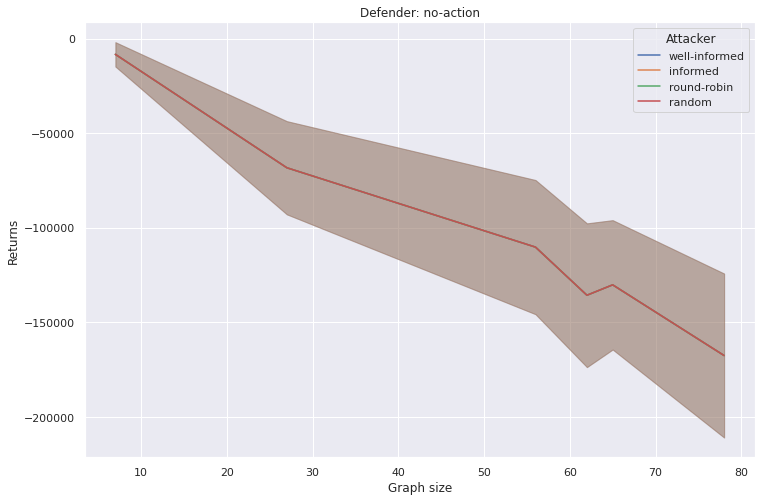

In [11]:
g = sns.lineplot(data=df, x="Graph size", y="Returns", hue="Attacker", ci="sd")
g.legend(title="Attacker", loc="upper right")
g.set_title("Defender: no-action")

Text(0.5, 1.0, 'Defender: no-action')

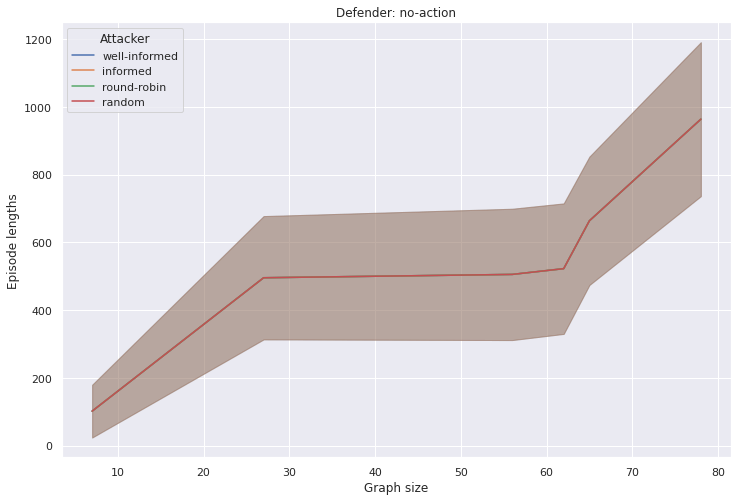

In [12]:
g = sns.lineplot(data=df, x="Graph size", y="Episode lengths", hue="Attacker", ci="sd")
g.legend(title="Attacker", loc="upper left")
g.set_title("Defender: no-action")

In [14]:
df.groupby("Attacker").describe()

Graph size                                                     \
                   count       mean        std  min   25%   50%   75%   max   
Attacker                                                                      
informed           180.0  49.166667  24.436098  7.0  27.0  59.0  65.0  78.0   
random             180.0  49.166667  24.436098  7.0  27.0  59.0  65.0  78.0   
round-robin        180.0  49.166667  24.436098  7.0  27.0  59.0  65.0  78.0   
well-informed      180.0  49.166667  24.436098  7.0  27.0  59.0  65.0  78.0   

              Returns                 ...                  Episode lengths  \
                count           mean  ...       75%    max           count   
Attacker                              ...                                    
informed        180.0 -103398.805556  ... -57299.25 -201.0           180.0   
random          180.0 -103398.805556  ... -57299.25 -201.0           180.0   
round-robin     180.0 -103398.805556  ... -57299.25 -201.0           180.0   
well-informed   180.0 -103398.805556  ... -57299.25 -201.0           180.0   

                                                                          
                     mean         std  min     25%    50%    75%     max  
Attacker                                                                  
informed       541.905556  313.126863  7.0  319.75  526.5  711.0  1436.0  
random         541.905556  313.126863  7.0  319.75  526.5  711.0  1436.0  
round-robin    541.905556  313.126863  7.0  319.75  526.5  711.0  1436.0  
well-informed  541.905556  313.126863  7.0  319.75  526.5  711.0  1436.0  

[4 rows x 24 columns]